Epoch: 1, Validation Loss: 0.30403657432864695, Validation Accuracy: 90.5632183908046%
Epoch: 2, Validation Loss: 0.19032448360367732, Validation Accuracy: 94.183908045977%
Epoch: 3, Validation Loss: 0.15542009452303104, Validation Accuracy: 95.04597701149426%
Epoch: 4, Validation Loss: 0.10750746266122031, Validation Accuracy: 96.48275862068965%
Epoch: 5, Validation Loss: 0.0887375296682448, Validation Accuracy: 97.29885057471265%
Epoch: 6, Validation Loss: 0.09626229143331703, Validation Accuracy: 97.05747126436782%
Epoch: 7, Validation Loss: 0.0801133951103753, Validation Accuracy: 97.52873563218391%
Epoch: 8, Validation Loss: 0.08609700169515289, Validation Accuracy: 97.57471264367815%
Epoch: 9, Validation Loss: 0.06702896576162483, Validation Accuracy: 97.9080459770115%
Epoch: 10, Validation Loss: 0.062271922721907576, Validation Accuracy: 98.13793103448276%


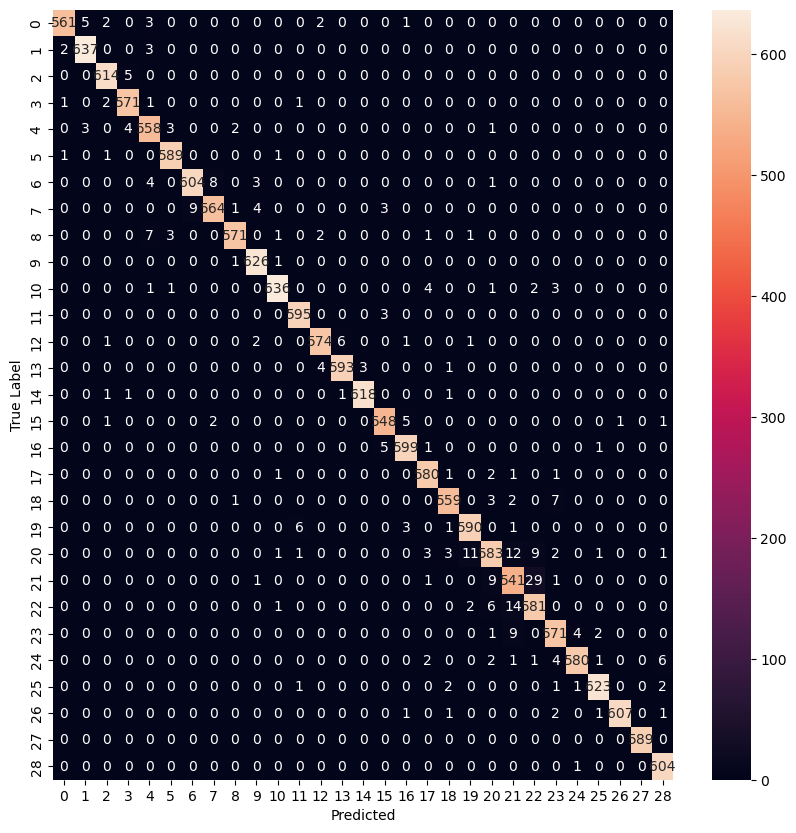

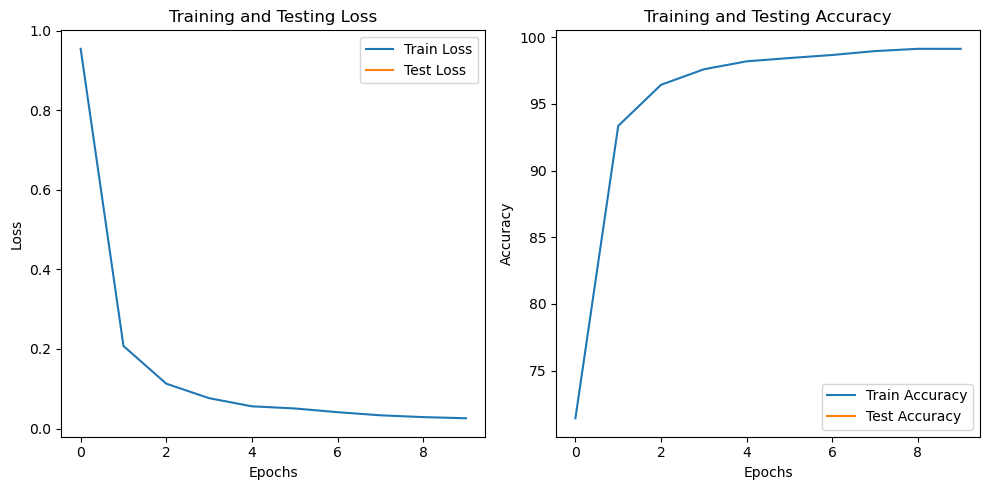

In [11]:
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns




# Hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 10


# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Image transformation and augmentation
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and split the dataset
dataset = datasets.ImageFolder(r'C:\Users\zhanq\Desktop\asl_alphabet_train', transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Further split test_dataset into test and validation sets
validation_size = int(0.5 * test_size)
test_size = test_size - validation_size
test_dataset, validation_dataset = random_split(test_dataset, [test_size, validation_size])

# DataLoader for validation set
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model architecture
# Two convolutional layers that preserve the input size (K=3, P=1, S=1, Y=[(W−K+2P)/S]+1=W)
# Each follow by a max pooling layer that halves the size of the input size.
# One droupout layer with rate 0.3 and one fully-connected layer.
class SignLanguageModel(nn.Module):
    def __init__(self):
        super(SignLanguageModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32*50*50, 29)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)
        
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x, 2)

        x = x.view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.fc1(x)
        return x

model = SignLanguageModel().to(device)

# Loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Helper function to calculate accuracy
def calculate_accuracy(output, labels):
    _, predicted = torch.max(output.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct, total

# Training loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        output = model(images)
        loss = loss_func(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_correct / train_total * 100)

    # Testing
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    # Validation
    model.eval()
    validation_loss = 0.0
    validation_correct = 0
    validation_total = 0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            loss = loss_func(output, labels)
            validation_loss += loss.item()
            correct, total = calculate_accuracy(output, labels)
            validation_correct += correct
            validation_total += total

    validation_accuracy = 100 * validation_correct / validation_total

    print(f'Epoch: {epoch+1}, Validation Loss: {validation_loss / len(validation_loader)}, Validation Accuracy: {validation_accuracy}%')

    
# Testing with confusion matrix
all_labels = []
all_predictions = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        _, predicted = torch.max(output.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.show()

# Plot the learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()

plt.tight_layout()
plt.show()